# AlexNet Architecture

In [9]:
import os
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Dropout
from tensorflow.keras.layers import BatchNormalization, ActivityRegularization, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.preprocessing import MultiLabelBinarizer

## AlexNet model

In [7]:
alexNet = Sequential()

# input layer
alexNet.add(Input(shape=(56, 56, 3)))

# first layer (conv_11x11, maxpool_3x3, batch_norm)
alexNet.add(Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), padding='same'))
alexNet.add(Activation(activation=relu))
alexNet.add(ActivityRegularization(l2=5e-4))
alexNet.add(MaxPooling2D(pool_size=(3,3),strides=(2,2), padding='same'))
alexNet.add(BatchNormalization())

# second layer (conv_5x5, maxpool_3x3, batch_norm)
alexNet.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same'))
alexNet.add(Activation(activation=relu))
alexNet.add(ActivityRegularization(l2=5e-4))
alexNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
alexNet.add(BatchNormalization())

# third layer (conv_3x3, batch_norm)
alexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
alexNet.add(Activation(activation=relu))
alexNet.add(ActivityRegularization(l2=5e-4))
alexNet.add(BatchNormalization())

# fourth layer (conv_3x3, batch_norm)
alexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
alexNet.add(Activation(activation=relu))
alexNet.add(ActivityRegularization(l2=5e-4))
alexNet.add(BatchNormalization())

# five layer (conv_3x3, batch_norm)
alexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
alexNet.add(Activation(activation=relu))
alexNet.add(ActivityRegularization(l2=5e-4))
alexNet.add(BatchNormalization())
alexNet.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

# flatten layer
alexNet.add(Flatten())

# classifier
alexNet.add(Dense(units=4096, activation=relu))
alexNet.add(Dropout(rate=0.5))

alexNet.add(Dense(units=4096, activation=relu))
alexNet.add(Dropout(rate=0.5))

alexNet.add(Dense(units=42, activation=sigmoid))

alexNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 96)        34944     
                                                                 
 activation (Activation)     (None, 14, 14, 96)        0         
                                                                 
 activity_regularization (Ac  (None, 14, 14, 96)       0         
 tivityRegularization)                                           
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 96)         0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 96)         384       
 ormalization)                                                   
                                                        

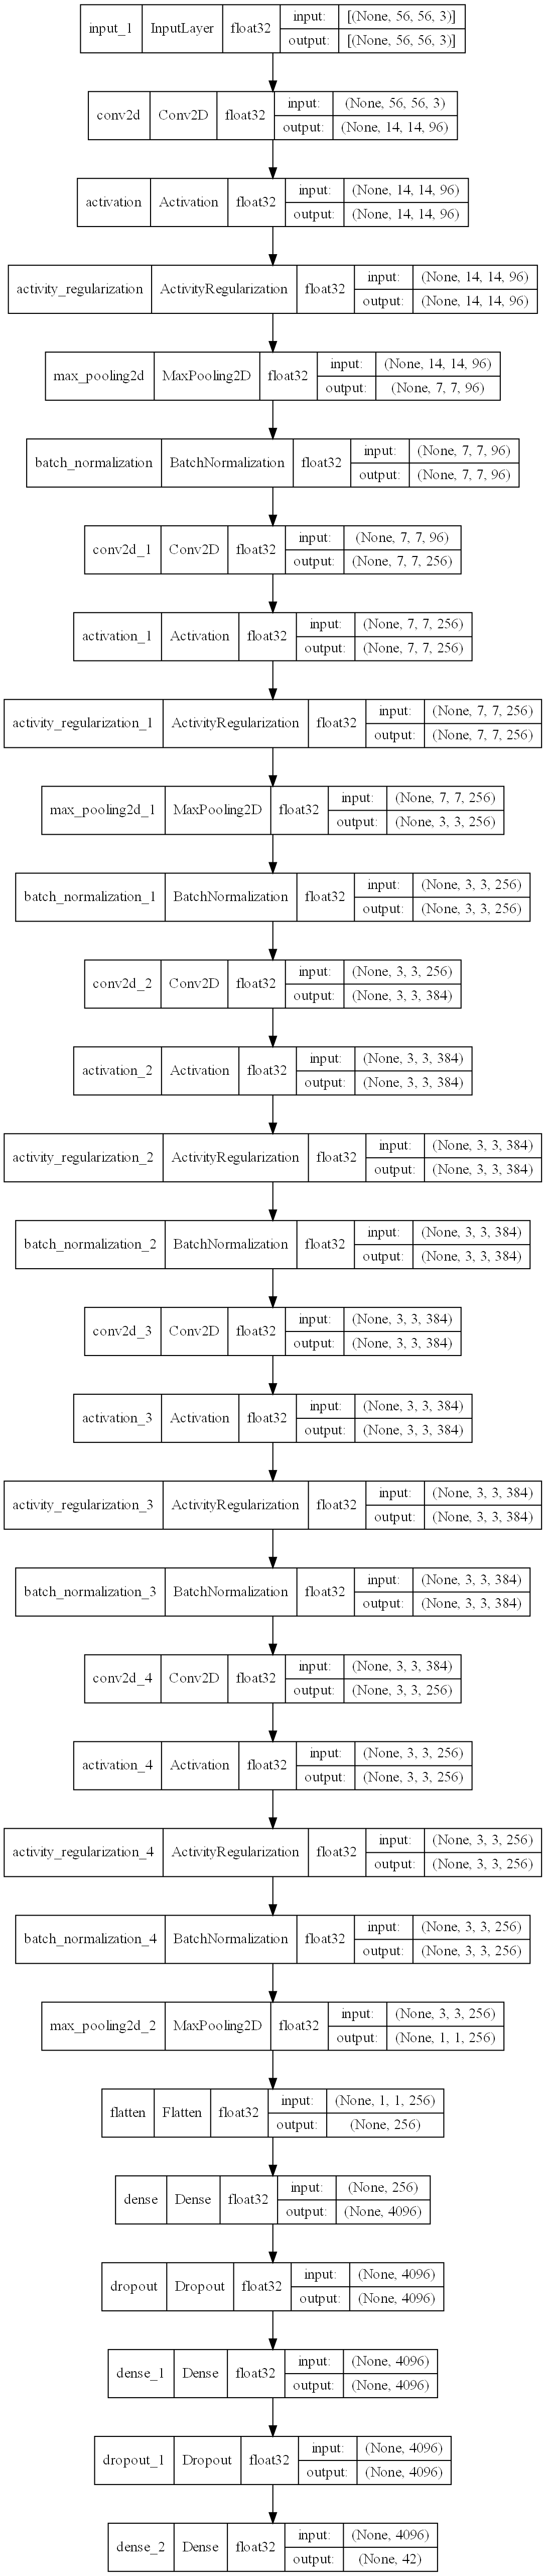

In [8]:
plot_model(model=alexNet,
           to_file='AlexNet.png',
           show_shapes=True,
           show_dtype=True,
           show_layer_names=True,
           dpi=150)

In [10]:
tree_types = os.listdir('../../data/image data/train')
X = []
y = []
val_x = []
val_y = []

for tree in tree_types:
    tree_path = os.path.join('../../data/image data/train', tree)
    tree_disease_types = os.listdir(tree_path)

    for disease in tree_disease_types:
        img_name = os.listdir(os.path.join(tree_path, disease))

        for img in img_name:
            image_path = os.path.join(tree_path, disease, img)
            image = img_to_array(load_img(image_path, target_size=(56, 56)))
            X.append(image)
            y.append([tree, disease])

for tree in tree_types:
    tree_path = os.path.join('../../data/image data/validation', tree)
    tree_disease_types = os.listdir(tree_path)

    for disease in tree_disease_types:
        img_name = os.listdir(os.path.join(tree_path, disease))

        for img in img_name:
            image_path = os.path.join(tree_path, disease, img)
            image = img_to_array(load_img(image_path, target_size=(56, 56)))
            val_x.append(image)
            val_y.append([tree, disease])


In [11]:
X = np.asarray(X)
val_x = np.asarray(val_x)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)
val_y = mlb.transform(val_y)
generator = ImageDataGenerator(rescale=1. / 255)

In [12]:
X.shape, y.shape, val_x.shape, val_y.shape

((38966, 56, 56, 3), (38966, 42), (9427, 56, 56, 3), (9427, 42))

In [13]:
train_gen = generator.flow(X, y, batch_size=32)
val_gen = generator.flow(val_x, val_y, batch_size=32)

#### training

In [14]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=np.sqrt(0.1))

check_point = ModelCheckpoint(filepath='alexNet.hdf5',
                              monitor='val_loss',
                              save_best_only=True)

callbacks = [reduce_lr, check_point]

In [15]:
alexNet.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
                loss=binary_crossentropy,
                metrics=['accuracy'])

In [ ]:
leNet_history = alexNet.fit(train_gen,
                          batch_size=32,
                          epochs=90,
                          callbacks=callbacks,
                          validation_data=val_gen)

Epoch 1/90
1218/1218 [==============================] - 89s 70ms/step - loss: 0.2438 - accuracy: 0.1413 - val_loss: 13.4996 - val_accuracy: 0.0215 - lr: 0.0100
Epoch 2/90
   7/1218 [..............................] - ETA: 1:15 - loss: 0.1604 - accuracy: 0.1339

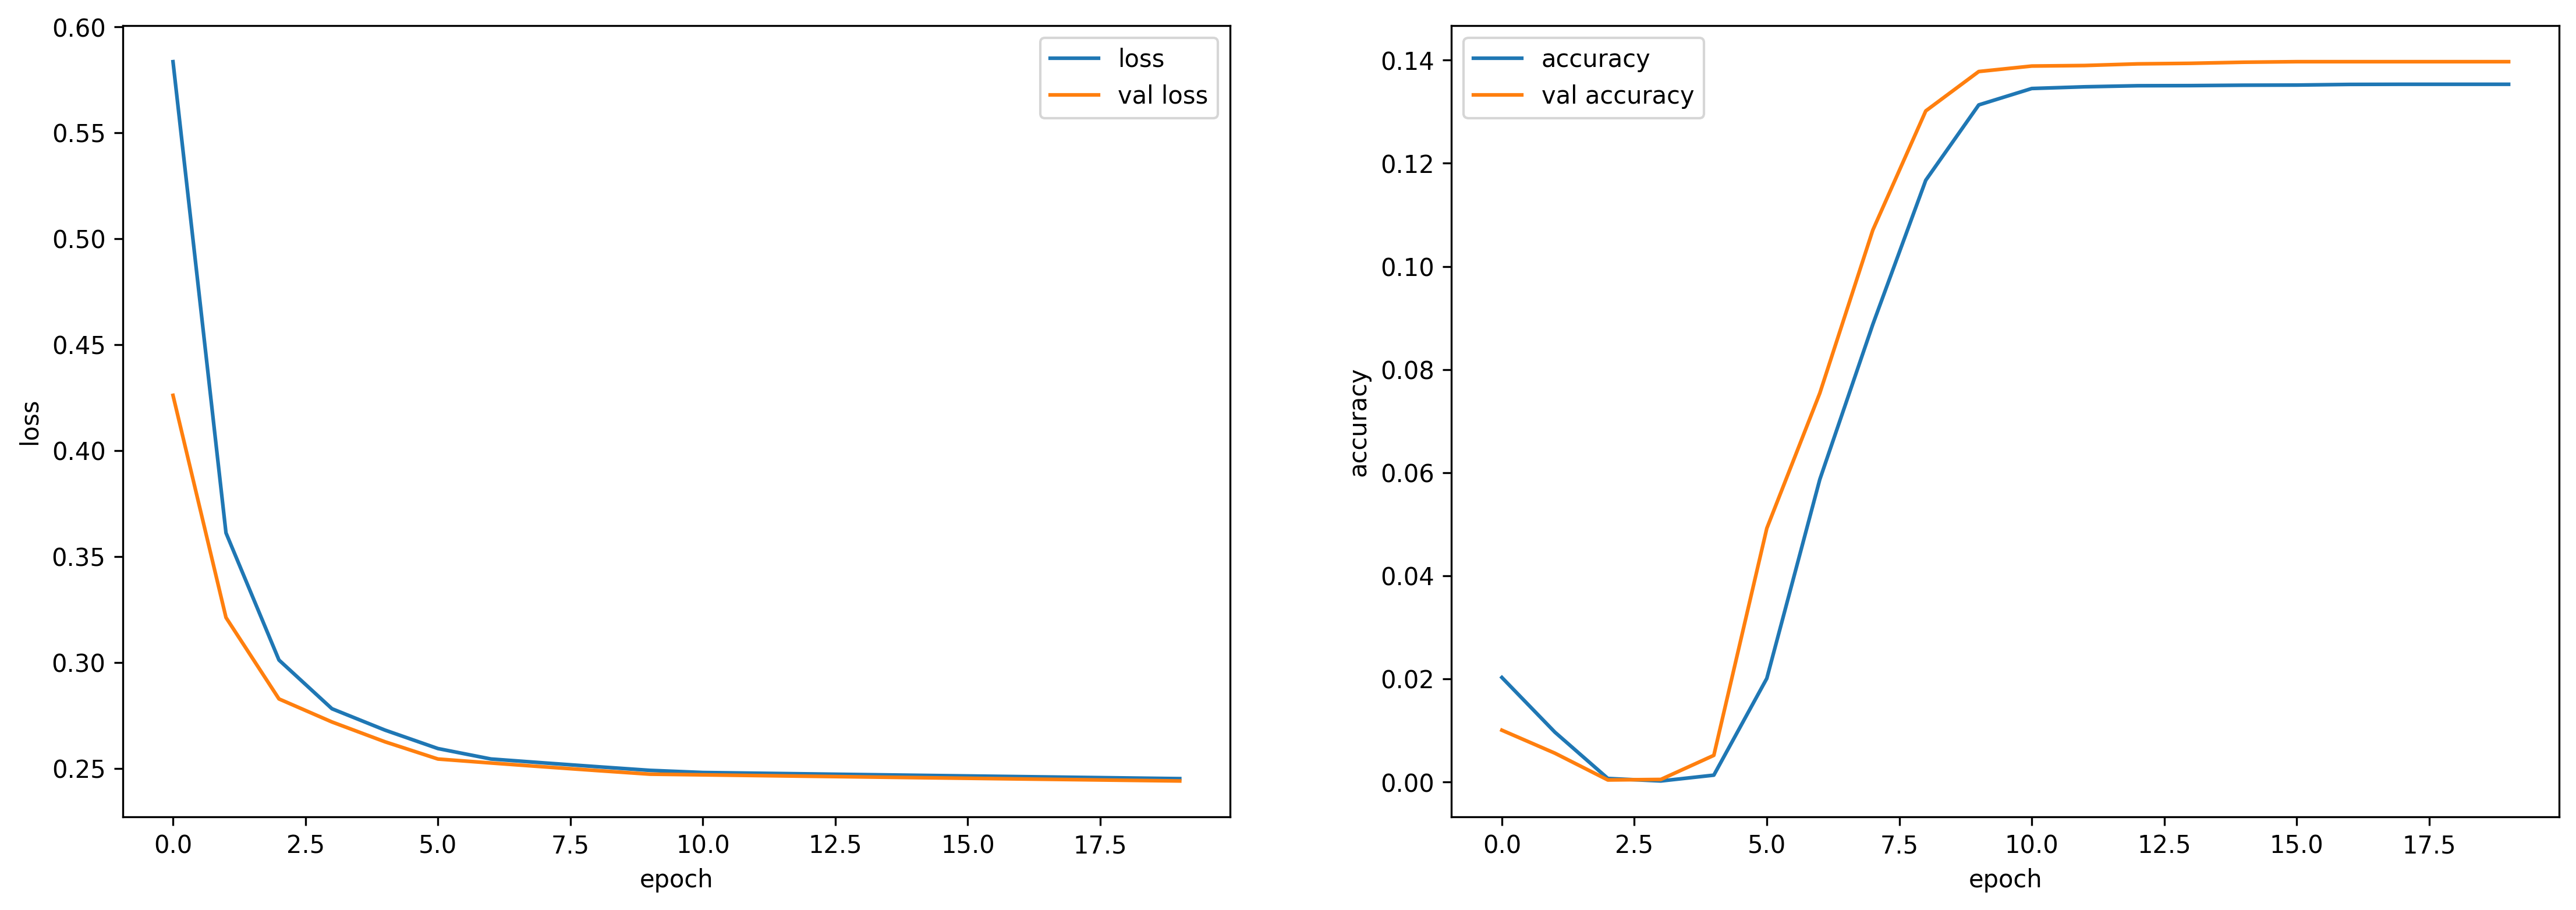

In [13]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=[18, 6], dpi=300)
axes = axes.ravel()
epochs = list(range(len(leNet_history.history['loss'])))

sns.lineplot(x=epochs, y=leNet_history.history['loss'], ax=axes[0], label='loss')
sns.lineplot(x=epochs, y=leNet_history.history['val_loss'], ax=axes[0], label='val loss')
sns.lineplot(x=epochs, y=leNet_history.history['accuracy'], ax=axes[1], label='accuracy')
sns.lineplot(x=epochs, y=leNet_history.history['val_accuracy'], ax=axes[1], label='val accuracy')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
plt.savefig('AlexNet_train_history.png')
plt.show()